# Imports

In [1]:
import dolfin as dl
import hippylib as hl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from spin.core import problem
from spin.fenics import converter
from spin.hippylib import hessian, laplace, misfit, optimization, prior

sns.set_theme(style="ticks")

# PDE Problem

In [2]:
mesh = dl.IntervalMesh(100, -1.5, 1.5)
problem_settings = problem.SPINProblemSettings(
    mesh=mesh,
    pde_type="mean_exit_time",
    inference_type="drift_only",
    log_squared_diffusion=("std::log(std::pow(x[0],2) + 2)",),
)
problem_builder = problem.SPINProblemBuilder(problem_settings)
spin_problem = problem_builder.build()

In [3]:
parameter_coordinates = spin_problem.coordinates_parameters
solution_coordinates = spin_problem.coordinates_variables
true_parameter = converter.create_dolfin_function(
    ("-2*std::pow(x[0],3) + 3*x[0]",), spin_problem.function_space_parameters
)
true_parameter = converter.convert_to_numpy(
    true_parameter.vector(), spin_problem.function_space_parameters
)
true_solution = spin_problem.solve_forward(true_parameter)
data_stride = 5
data_locations = solution_coordinates[4:-5:data_stride]
data_values = true_solution[4:-5:data_stride]
rng = np.random.default_rng(seed=0)
noise_std = 0.01
noise = rng.normal(loc=0, scale=noise_std, size=data_values.size)
data_values = data_values + noise

right_hand_side = 0.1 * np.ones_like(true_solution)
true_adjoint = spin_problem.solve_adjoint(true_solution, true_parameter, right_hand_side)
true_gradient = spin_problem.evaluate_gradient(true_solution, true_parameter, right_hand_side)

Text(0, 0.5, '$g(x)$')

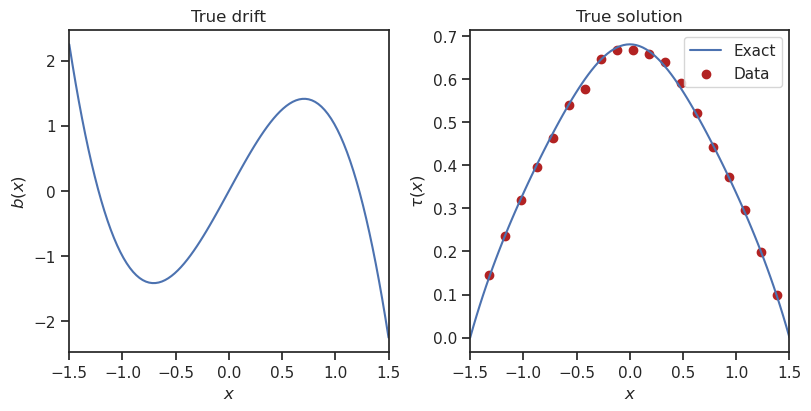

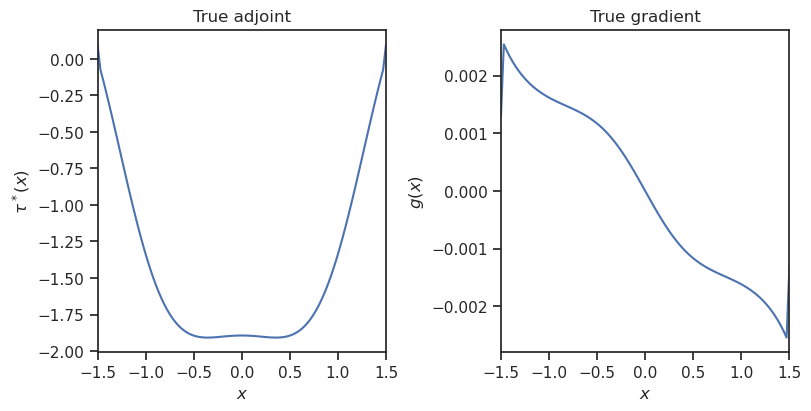

In [4]:
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout="constrained")
axs[0].plot(parameter_coordinates, true_parameter)
axs[0].set_xlim(-1.5, 1.5)
axs[0].set_title("True drift")
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$b(x)$")
axs[1].plot(solution_coordinates, true_solution, label="Exact")
axs[1].scatter(data_locations, data_values, color="firebrick", label="Data")
axs[1].set_xlim(-1.5, 1.5)
axs[1].set_title("True solution")
axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$\tau(x)$")
axs[1].legend()

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout="constrained")
axs[0].plot(solution_coordinates, true_adjoint)
axs[0].set_xlim(-1.5, 1.5)
axs[0].set_title("True adjoint")
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$\tau^*(x)$")
axs[1].plot(parameter_coordinates, true_gradient)
axs[1].set_xlim(-1.5, 1.5)
axs[1].set_title("True gradient")
axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$g(x)$")

# Prior

Text(0, 0.5, '$\\beta$')

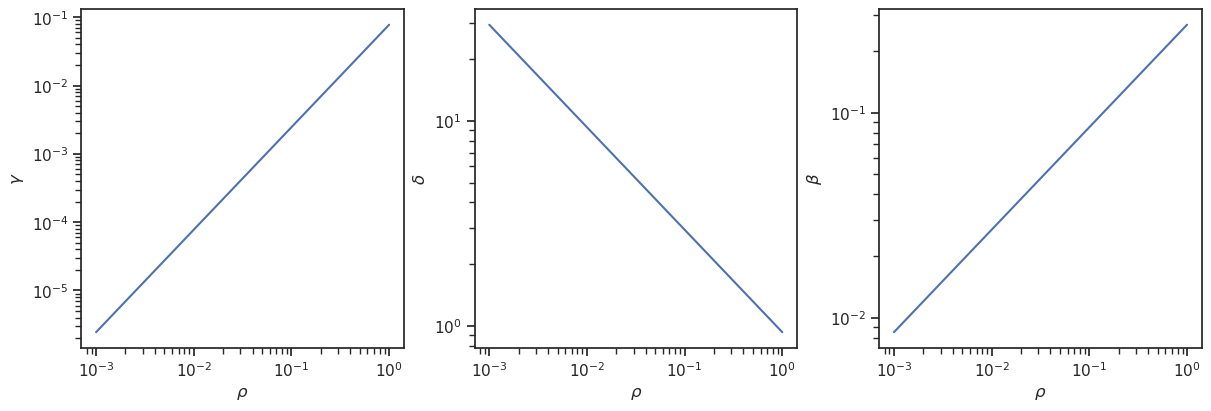

In [5]:
test_variance = 1.0
test_correlation_lengths = np.logspace(-3, 0, num=100)
gamma_list = []
delta_list = []
for correlation_length in test_correlation_lengths:
    gamma, delta = hl.BiLaplacianComputeCoefficients(test_variance, correlation_length, 1)
    gamma_list.append(gamma)
    delta_list.append(delta)
gamma = np.array(gamma_list)
delta = np.array(delta_list)
beta = np.sqrt(gamma * delta)

_, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), layout="constrained")
axs[0].loglog(test_correlation_lengths, gamma)
axs[0].set_xlabel(r"$\rho$")
axs[0].set_ylabel(r"$\gamma$")
axs[1].loglog(test_correlation_lengths, delta)
axs[1].set_xlabel(r"$\rho$")
axs[1].set_ylabel(r"$\delta$")
axs[2].loglog(test_correlation_lengths, beta)
axs[2].set_xlabel(r"$\rho$")
axs[2].set_ylabel(r"$\beta$")

In [17]:
prior_settings = prior.PriorSettings(
    function_space=spin_problem.function_space_parameters,
    mean=("-x[0]",),
    variance=("1",),
    correlation_length=("1",),
    robin_bc=True,
)
prior_builder = prior.BilaplacianVectorPriorBuilder(prior_settings)
spin_prior = prior_builder.build()
prior_variance = spin_prior.compute_variance_with_boundaries(
    method="Randomized", num_eigenvalues_randomized=100
)
prior_precision = spin_prior.compute_precision_with_boundaries()
condition_number = np.linalg.cond(prior_precision)
eigenvalues = np.linalg.eig(prior_precision)

true_parameter = converter.create_dolfin_function(
    ("-2*std::pow(x[0],3) + 3*x[0]",),
    spin_problem.function_space_parameters,
)
prior_grad_vector = dl.Vector(true_parameter.vector())
spin_prior.hippylib_prior.grad(true_parameter.vector(), prior_grad_vector)
prior_grad_array = converter.convert_to_numpy(
    prior_grad_vector, spin_problem.function_space_parameters
)

print(condition_number)
print(np.min(eigenvalues.eigenvalues))
print(np.max(eigenvalues.eigenvalues))

369149.6996737597
0.028990236858481993
10701.737229918863


(-1.5, 1.5)

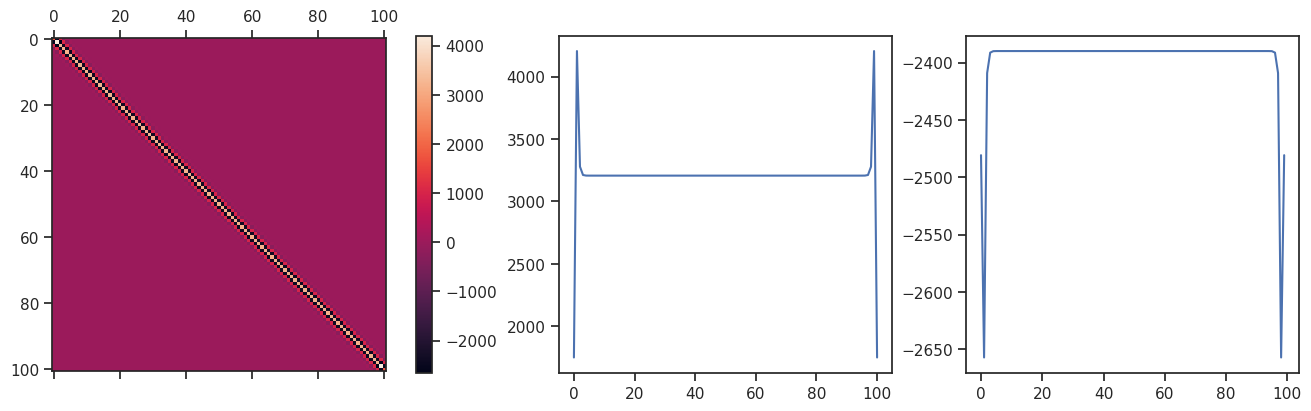

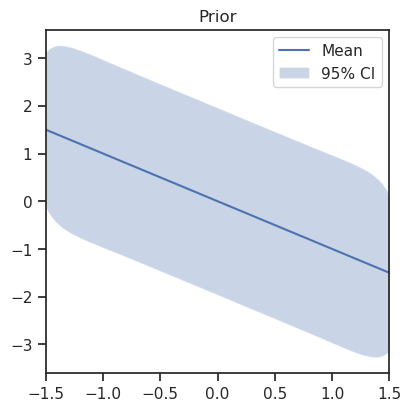

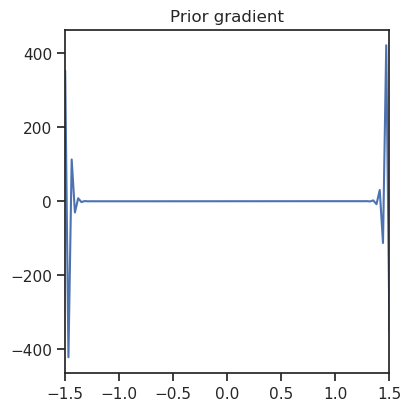

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(13, 4), layout="constrained")
matplot = axs[0].matshow(prior_precision)
fig.colorbar(matplot, ax=axs[0])
axs[1].plot(np.diagonal(prior_precision, offset=0), label="diagonal")
axs[2].plot(np.diagonal(prior_precision, offset=1), label="off-diagonal")
_, ax = plt.subplots(figsize=(4, 4), layout="constrained")
ax.plot(parameter_coordinates, spin_prior.mean_array, label="Mean")
ax.fill_between(
    parameter_coordinates.flatten(),
    spin_prior.mean_array - 1.96 * np.sqrt(prior_variance),
    spin_prior.mean_array + 1.96 * np.sqrt(prior_variance),
    alpha=0.3,
    label="95% CI",
)
ax.set_title("Prior")
ax.set_xlim(-1.5, 1.5)
ax.legend()

_, ax = plt.subplots(figsize=(4, 4), layout="constrained")
ax.plot(parameter_coordinates, prior_grad_array)
ax.set_title("Prior gradient")
ax.set_xlim(-1.5, +1.5)

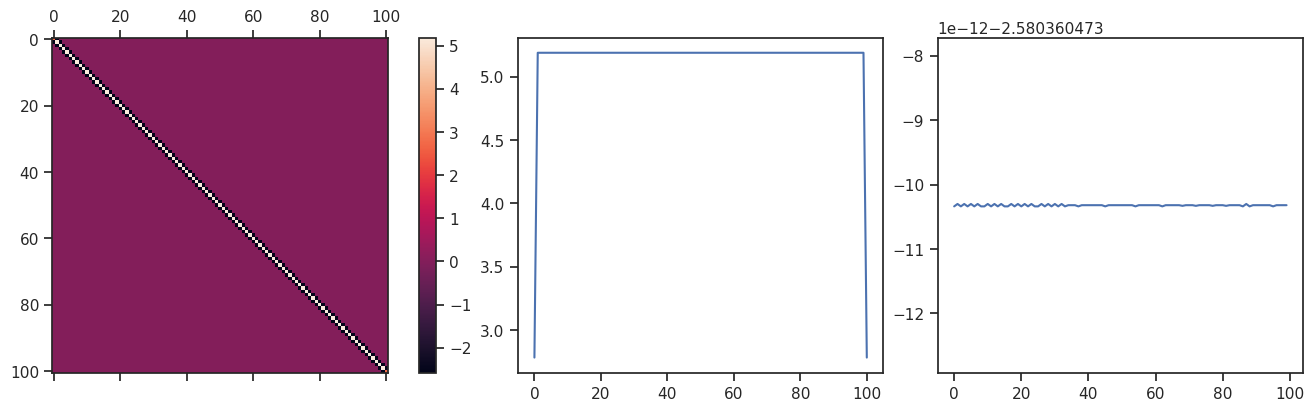

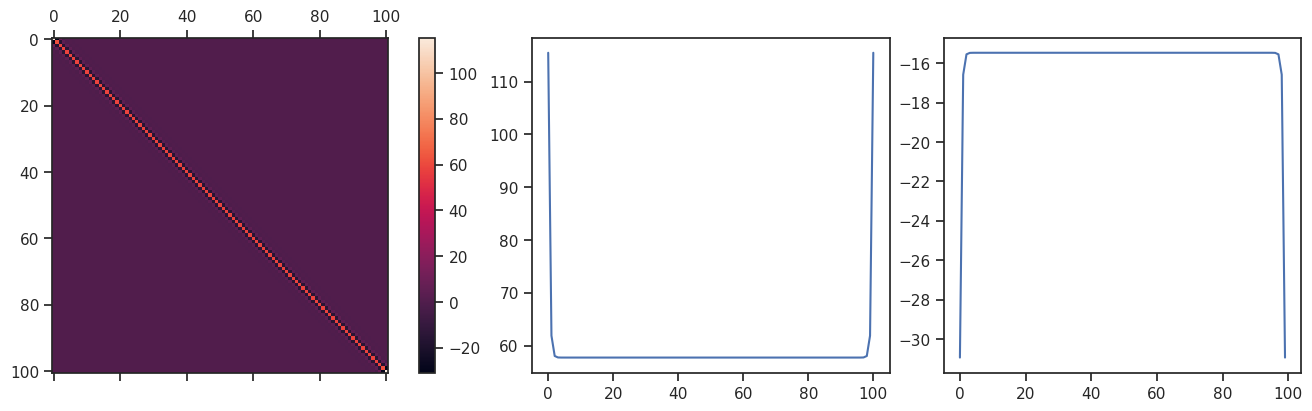

In [19]:
spde_matrix = spin_prior.spde_matern_matrix.toarray()
inv_mass_matrix = np.linalg.inv(spin_prior.mass_matrix.toarray())

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(13, 4), layout="constrained")
matplot = axs[0].matshow(spde_matrix)
fig.colorbar(matplot, ax=axs[0])
axs[1].plot(np.diagonal(spde_matrix, offset=0), label="diagonal")
axs[2].plot(np.diagonal(spde_matrix, offset=1), label="off-diagonal")

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(13, 4), layout="constrained")
matplot = axs[0].matshow(inv_mass_matrix)
fig.colorbar(matplot, ax=axs[0])
axs[1].plot(np.diagonal(inv_mass_matrix, offset=0), label="diagonal")
axs[2].plot(np.diagonal(inv_mass_matrix, offset=1), label="off-diagonal")

# Misfit

In [9]:
misfit_settings = misfit.MisfitSettings(
    function_space=spin_problem.function_space_variables,
    observation_points=data_locations,
    observation_values=data_values,
    noise_variance=np.ones(data_locations.size) * noise_std**2,
)
misfit_builder = misfit.MisfitBuilder(misfit_settings)
spin_misfit = misfit_builder.build()

discrepancy = data_values - spin_misfit.observation_matrix @ true_solution
misfit_grad = spin_misfit.observation_matrix.T @ spin_misfit.noise_precision_matrix @ discrepancy

Text(0.5, 0, '$x$')

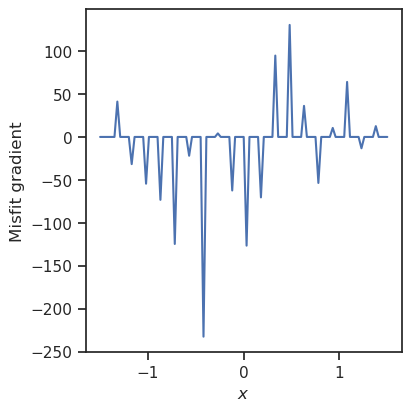

In [10]:
_, ax = plt.subplots(figsize=(4, 4), layout="constrained")
ax.plot(solution_coordinates, misfit_grad)
ax.set_ylabel("Misfit gradient")
ax.set_xlabel(r"$x$")

# Optimization

In [11]:
inference_model = hl.Model(
    spin_problem.hippylib_variational_problem,
    spin_prior.hippylib_prior,
    spin_misfit.hippylib_misfit,
)

In [12]:
optimization_settings = optimization.SolverSettings(
    relative_tolerance=1e-6, absolute_tolerance=1e-4, verbose=True
)
initial_guess = spin_prior.mean_array
newton_solver = optimization.NewtonCGSolver(optimization_settings, inference_model)
solver_solution = newton_solver.solve(initial_guess)
print("Termination reason:", solver_solution.termination_reason)


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    3.684302e+04    3.684132e+04    1.702862e+00   -5.169121e+04   3.219192e+04   1.000000e+00   5.000000e-01
  2   1    2.403539e+04    2.403147e+04    3.912409e+00   -3.743943e+03   4.510787e+03   1.000000e+00   3.743283e-01
  3   1    2.221250e+04    2.220805e+04    4.452298e+00   -7.727732e+01   4.758726e+02   1.000000e+00   1.215827e-01
  4   5    2.215977e+04    2.215479e+04    4.976272e+00   -9.475326e+00   3.734369e+01   1.000000e+00   3.405925e-02
  5   5    2.213282e+04    2.212783e+04    4.987582e+00   -3.676713e-02   6.771457e+00   1.000000e+00   1.450333e-02
  6   8    2.213282e+04    2.212783e+04    4.987588e+00   -2.056977e-04   1.481244e-01   9.765625e-04   2.145062e-03
Termination reason: Maximum number of backtracking reached


# Low-Rank Hessian

In [13]:
hessian_settings = hessian.LowRankHessianSettings(
    num_eigenvalues=15,
    num_oversampling=5,
    inference_model=inference_model,
    evaluation_point=[
        solver_solution.forward_solution,
        solver_solution.optimal_parameter,
        solver_solution.adjoint_solution,
    ],
)
eigenvalues, eigenvectors = hessian.compute_low_rank_hessian(hessian_settings)

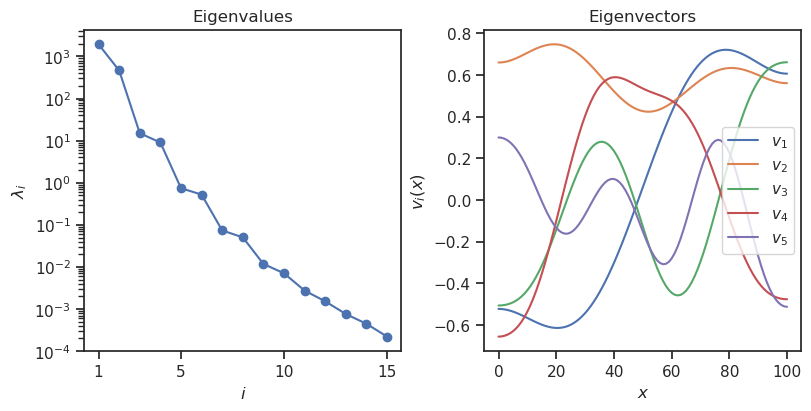

In [14]:
index_vector = np.arange(1, eigenvalues.size + 1)
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout="constrained")
axs[0].semilogy(index_vector, eigenvalues, marker="o")
axs[0].set_title("Eigenvalues")
axs[0].set_xticks((1, 5, 10, 15))
axs[0].set_xlabel(r"$i$")
axs[0].set_ylabel(r"$\lambda_i$")
for i in range(5):
    axs[1].plot(eigenvectors[i], label=f"$v_{i + 1}$")
axs[1].set_title("Eigenvectors")
axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$v_i(x)$")
axs[1].legend()

# Laplace Approximation

In [15]:
laplace_approximation_settings = laplace.LowRankLaplaceApproximationSettings(
    inference_model=inference_model,
    mean=solver_solution.optimal_parameter,
    low_rank_hessian_eigenvalues=eigenvalues,
    low_rank_hessian_eigenvectors=eigenvectors,
)
laplace_approximation = laplace.LowRankLaplaceApproximation(laplace_approximation_settings)
posterior_variance = laplace_approximation.compute_pointwise_variance(
    method="Randomized", num_eigenvalues_randomized=500
)

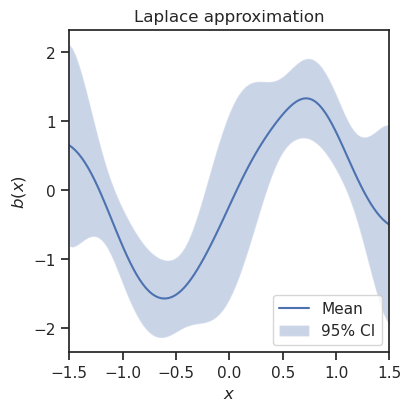

In [16]:
_, ax = plt.subplots(figsize=(4, 4), layout="constrained")
ax.plot(parameter_coordinates, solver_solution.optimal_parameter, label="Mean")
ax.fill_between(
    parameter_coordinates.flatten(),
    solver_solution.optimal_parameter - 1.96 * np.sqrt(posterior_variance),
    solver_solution.optimal_parameter + 1.96 * np.sqrt(posterior_variance),
    alpha=0.3,
    label="95% CI",
)
ax.set_title("Laplace approximation")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$b(x)$")
ax.set_xlim((-1.5, 1.5))
ax.legend()